In [1]:
##Import Modules
import mlrose_hiive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

def getMax(arr):
    maxVal = -1
    index = -1
    for i in range(len(arr)):
        if(maxVal < arr[i]):
            maxVal = arr[i]
            index = i
    return {'index': index,
           'maximum_value': maxVal}

def getF1(trainSize, testMean):
    max_test = getMax(testMean)
    index = max_test['index']
    maxValue = max_test['maximum_value']
    optimalTrainSize = trainSize[index]
    conclusion = f'With the train size of {optimalTrainSize} yields the f1 score of {maxValue}.'
    return conclusion

def prediction(df, xTrain, yTrain, xTest, yTest):
    output = {}
    start = time.time()
    df.fit(xTrain, yTrain)
    test_pred = df.predict(xTest)
    cRep = classification_report(yTest, test_pred, digits=4)
    f1Score = f1_score(yTest, test_pred)
    end = time.time()
    wallClockPred = end - start
    outputUpdate = (('classification_report', cRep), ('f1_score', f1Score), ('wall_clock', wallClockPred))
    output.update(outputUpdate)
    return output

def printPredictions(pred):
    print('Time spent for prediction: ', pred['wall_clock'])
    print(pred['classification_report'])
    print('f1-Score: ', pred['f1_score'])

def getTime(algo, xTrain, yTrain):
    start = time.time()
    algo.fit(xTrain, yTrain)
    end = time.time()
    difference = end-start
    return difference

def trainNeuralNetwork(algorithm, accuracies, elapsedTimes, xTrain, yTrain, xTest, yTest, iteration=100, maxAttempts=5, schedule=mlrose_hiive.GeomDecay(), restarts=0, popSize=200, mutationProb=0.1):
    
    scaler = StandardScaler()
    scaler.fit(xTrain)
    scaledXTrain = scaler.transform(xTrain)
    scaledXTest = scaler.transform(xTest) 
    
    algorithmModel = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], activation='relu',algorithm=algorithm,
                                                max_iters=iteration,
                                                bias=True, is_classifier=True, early_stopping=True,
                                                schedule=schedule, restarts=restarts, pop_size=popSize, mutation_prob=mutationProb,
                                                learning_rate=0.1, max_attempts=maxAttempts, random_state=44)
    
    elapsedTime = getTime(algorithmModel, scaledXTrain, yTrain) ##check here bc algorithmmodel.fit
    ##predict labels for train set
    yTrainPred = algorithmModel.predict(scaledXTrain)
    yTestPred = algorithmModel.predict(scaledXTest)
    yTestAcc = accuracy_score(yTest, yTestPred)
    
    accuracies.append(yTestAcc)
    elapsedTimes.append(elapsedTime)
    return algorithmModel

def plotNeuralNetworkOptimization(algorithm, accuracies, elapsedTimes, xTrain, yTrain, xTest, yTest, iterations, schedule=mlrose_hiive.GeomDecay(), restarts=0, popSize=200, mutationProb=0.1):
    algorithmModel = None
    
    if(algorithm == 'simulated_annealing'):
        schedule=mlrose_hiive.ExpDecay(init_temp=1.0, exp_const=0.01, min_temp=0.0001)
    elif(algorithm == 'random_hill_climb'):
        restarts=100
    elif(algorithm == 'genetic_alg'):
        popSize=100
        mutationProb=0.2
        
    for i in iterations:
        algorithmModel = trainNeuralNetwork(algorithm, accuracies, elapsedTimes, xTrain, yTrain, xTest, yTest, i, schedule=schedule, restarts=restarts, popSize=popSize, mutationProb=mutationProb)
    
    return algorithmModel
    
def plotInOne(iterationList, saTimes, saAcc, rhcTimes, rhcAcc, gaTimes, gaAcc):
    plt.figure(figsize=(12, 7))
    plt.plot(iterationList, saTimes, label="Simulated Annealing")
    plt.plot(iterationList, rhcTimes, label="Random Hill Climbbing")
    plt.plot(iterationList, gaTimes, label="Genetic Algorithm")
    
    plt.title("Neural Network Time(sec) vs Iterations")
    plt.xlabel("Iteration #")
    plt.ylabel("Time Elapsed")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 7))
    plt.plot(iterationList, saAcc, label="Simulated Annealing")
    plt.plot(iterationList, rhcAcc, label="Random Hill Climbbing")
    plt.plot(iterationList, gaAcc, label="Genetic Algorithm")
    
    plt.title("Neural Network Accuracies vs Iterations")
    plt.xlabel("Iteration #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
##load the file and update the column names
##https://archive.ics.uci.edu/ml/datasets/Heart+Disease data source
df = pd.read_csv('/Users/jacobseo/cs7641/assignment2/data/processed.cleveland.data', header=None)

df.columns = ['age','sex','chestPain','restingBloodPressure','cholesterol','fastingBloodSugar','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

messy_df = df.loc[(df['ca'] == '?') | (df['thal'] == '?')]
clean_df = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]
##data Split to independent variable
X = clean_df.drop('num', axis=1).copy()

y = clean_df['num'].copy()

## category attriutes into binary format
pd.get_dummies(X, columns=['chestPain']).head()

X_encoded = pd.get_dummies(X, columns=['chestPain', 'restecg','slope','thal'])
#X_encoded.head()

y_nonZeroIndex = y > 0
y[y_nonZeroIndex] = 1
#y.unique()

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)


In [2]:
saAcc = []
saTimes = []

rhcAcc = []
rhcTimes = []

gaAcc = []
gaTimes = []

iterations = range(1, 5000, 500)

#X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
nnSA = plotNeuralNetworkOptimization('simulated_annealing', saAcc, saTimes, X_train, y_train, X_test, y_test, iterations)
nnRHC = plotNeuralNetworkOptimization('random_hill_climb', rhcAcc, rhcTimes, X_train, y_train, X_test, y_test, iterations)
nnGA = plotNeuralNetworkOptimization('genetic_alg', gaAcc, gaTimes, X_train, y_train, X_test, y_test, iterations)

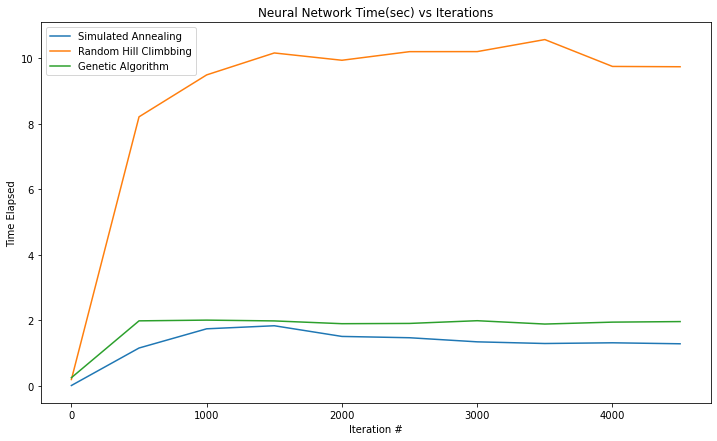

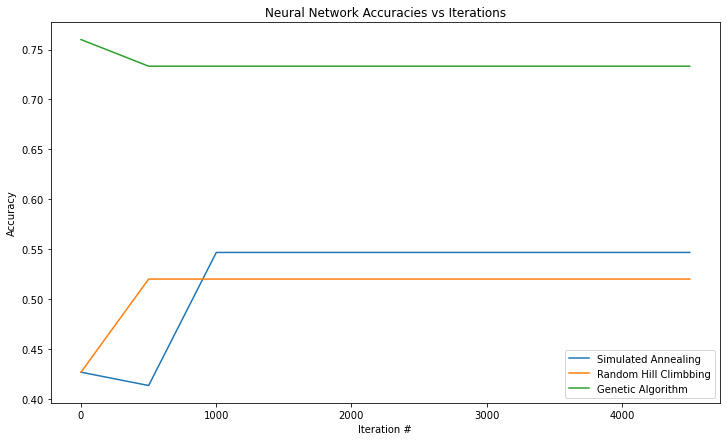

In [3]:
plotInOne(iterations, saTimes, saAcc, rhcTimes, rhcAcc, gaTimes, gaAcc)